In [59]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
import numpy as np

In [3]:
# Incarcare date din CSV
file_path = 'licee_all.csv'
data = pd.read_csv(file_path)
# Redenumirea județului "MUNICIPIUL BUCURESTI" ca "BUCURESTI"
data.loc[data['Judet'] == 'MUNICIPIUL BUCURESTI', 'Judet'] = 'BUCURESTI'

In [4]:
print(data.columns)

Index(['Judet', 'idSchool', 'bulgara', 'croata', 'engleza', 'germana',
       'italiana', 'maghiara', 'neogreaca', 'polona', 'romana', 'romani',
       'rusa', 'sarba', 'slovaca', 'ucraineana', 'Nr_elevi', 'Nr_profesori',
       'Elevi_cu_BAC', 'Ateliere_scolare', 'Laboratoare', 'Echipamente',
       'Terenuri_sport', 'Imigranti'],
      dtype='object')


In [5]:
print(data.head())

   Judet  idSchool  bulgara  croata  engleza  germana  italiana  maghiara  \
0   ALBA        36        0       0        0        1         0         2   
1   ARAD        41        0       0        0        1         0         1   
2  ARGES        43        0       0        0        0         0         0   
3  BACAU        36        0       0        0        0         0         0   
4  BIHOR        51        0       0        0        1         0        14   

   neogreaca  polona  ...  slovaca  ucraineana  Nr_elevi  Nr_profesori  \
0          0       0  ...        0           0     21419          2416   
1          0       0  ...        1           0     31643          3166   
2          0       0  ...        0           0     29802          3057   
3          0       0  ...        0           0     27915          3055   
4          0       0  ...        1           0     41575          4430   

   Elevi_cu_BAC  Ateliere_scolare  Laboratoare  Echipamente  Terenuri_sport  \
0          18

In [8]:
data_fara_jud_id = data.drop(columns=['Judet','idSchool'])
print(data_fara_jud_id)

    bulgara  croata  engleza  germana  italiana  maghiara  neogreaca  polona  \
0         0       0        0        1         0         2          0       0   
1         0       0        0        1         0         1          0       0   
2         0       0        0        0         0         0          0       0   
3         0       0        0        0         0         0          0       0   
4         0       0        0        1         0        14          0       0   
5         0       0        0        1         0         1          0       0   
6         0       0        0        0         0         0          0       0   
7         0       0        0        0         0         0          0       0   
8         0       0        0        3         0         4          0       0   
9         0       0        0        0         0         0          0       0   
10        0       0        0        0         0         0          0       0   
11        0       1        0        1   

### Normalizarea datelor - Outliere

In [91]:
lower_limit = data_fara_jud_id.quantile(0.05)
upper_limit = data_fara_jud_id.quantile(0.95)
# Nullify outlieres
data_clipped = data_fara_jud_id.clip(lower=lower_limit, upper=upper_limit, axis=1)

In [11]:
print(lower_limit)
print(upper_limit)

bulgara                 0.00
croata                  0.00
engleza                 0.00
germana                 0.00
italiana                0.00
maghiara                0.00
neogreaca               0.00
polona                  0.00
romana                 12.25
romani                  0.00
rusa                    0.00
sarba                   0.00
slovaca                 0.00
ucraineana              0.00
Nr_elevi            10614.65
Nr_profesori         1188.85
Elevi_cu_BAC          829.55
Ateliere_scolare       30.25
Laboratoare            70.60
Echipamente          1902.00
Terenuri_sport         16.05
Imigranti              85.40
Name: 0.05, dtype: float64
bulgara                 0.00
croata                  0.00
engleza                 0.00
germana                 2.95
italiana                0.00
maghiara               14.00
neogreaca               0.00
polona                  0.00
romana                 60.65
romani                  0.00
rusa                    0.00
sarba           

### Corelatii

In [12]:
corelatii = data_fara_jud_id.corr()
print(corelatii)

                   bulgara    croata   engleza   germana  italiana  maghiara  \
bulgara           1.000000 -0.024390 -0.033047  0.075885  1.000000 -0.048251   
croata           -0.024390  1.000000 -0.033047  0.075885 -0.024390 -0.072377   
engleza          -0.033047 -0.033047  1.000000  0.027058 -0.033047  0.163441   
germana           0.075885  0.075885  0.027058  1.000000  0.075885  0.169876   
italiana          1.000000 -0.024390 -0.033047  0.075885  1.000000 -0.048251   
maghiara         -0.048251 -0.072377  0.163441  0.169876 -0.048251  1.000000   
neogreaca         1.000000 -0.024390 -0.033047  0.075885  1.000000 -0.048251   
polona           -0.024390 -0.024390 -0.033047 -0.091861 -0.024390 -0.072377   
romana            0.722529 -0.032053  0.328353  0.231718  0.722529 -0.155296   
romani            1.000000 -0.024390 -0.033047  0.075885  1.000000 -0.048251   
rusa              1.000000 -0.024390 -0.033047  0.075885  1.000000 -0.048251   
sarba            -0.024390 -0.024390 -0.

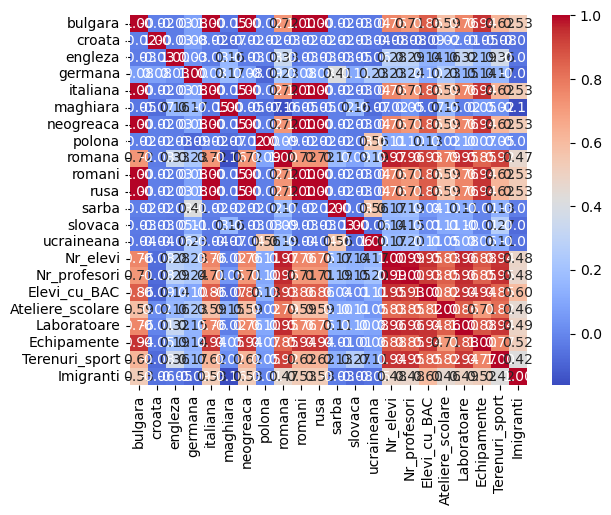

In [14]:
sns.heatmap(corelatii, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
# Se oberva corelatii cu valori ridicate in partea de jos a tabelului

In [16]:
threshold = 0.7
coloane_eliminate = set()

for i in range(len(corelatii.columns)):
    for j in range(i):
        if (corelatii.iloc[i, j] >= threshold) and (corelatii.columns[j] not in coloane_eliminate):
            coloane_eliminate.add(corelatii.columns[i])

# Eliminare a coloanelor cu corelatii ridicate ce apar de mai multe ori
data_fara_corelatii_ridicate = data.drop(list(coloane_eliminate), axis=1)
print(data_fara_corelatii_ridicate)
# Se observa ca raman putine coloane din cele de la sfarsitul tabelului

              Judet  idSchool  bulgara  croata  engleza  germana  maghiara  \
0              ALBA        36        0       0        0        1         2   
1              ARAD        41        0       0        0        1         1   
2             ARGES        43        0       0        0        0         0   
3             BACAU        36        0       0        0        0         0   
4             BIHOR        51        0       0        0        1        14   
5   BISTRITA-NASAUD        27        0       0        0        1         1   
6          BOTOSANI        29        0       0        0        0         0   
7            BRAILA        22        0       0        0        0         0   
8            BRASOV        42        0       0        0        3         4   
9             BUZAU        33        0       0        0        0         0   
10         CALARASI        17        0       0        0        0         0   
11    CARAS-SEVERIN        31        0       1        0        1

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

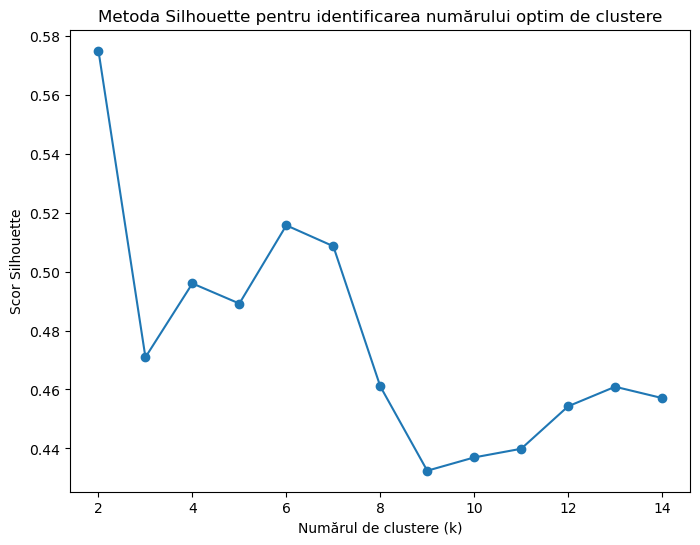

In [22]:
from sklearn.metrics import silhouette_score

X = data_clipped

scoruri_silhouette = []
nr_clustere = range(2, 15)  

for k in nr_clustere:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scor_silhouette = silhouette_score(X, kmeans.labels_)
    scoruri_silhouette.append(scor_silhouette)

# Plotare grafic Silhouette
plt.figure(figsize=(8, 6))
plt.plot(nr_clustere, scoruri_silhouette, marker='o')
plt.xlabel('Numărul de clustere (k)')
plt.ylabel('Scor Silhouette')
plt.title('Metoda Silhouette pentru identificarea numărului optim de clustere')
plt.show()

In [37]:
y = data['Judet']

numar_clustere = 6
kmeans = KMeans(n_clusters=numar_clustere)
kmeans.fit(data_clipped)

etichete = kmeans.labels_
rezultate = pd.DataFrame({'Judet': y, 'Eticheta_Cluster': etichete})
print(rezultate)

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Judet  Eticheta_Cluster
0              ALBA                 3
1              ARAD                 0
2             ARGES                 0
3             BACAU                 0
4             BIHOR                 2
5   BISTRITA-NASAUD                 3
6          BOTOSANI                 5
7            BRAILA                 1
8            BRASOV                 0
9             BUZAU                 3
10         CALARASI                 1
11    CARAS-SEVERIN                 3
12             CLUJ                 2
13        CONSTANTA                 2
14          COVASNA                 1
15        DAMBOVITA                 3
16             DOLJ                 2
17           GALATI                 5
18          GIURGIU                 1
19             GORJ                 3
20         HARGHITA                 3
21        HUNEDOARA                 0
22         IALOMITA                 1
23             IASI                 4
24            ILFOV                 3
25        MA

In [38]:
from sklearn.metrics import silhouette_score
df = pd.DataFrame(rezultate)

silhouette_avg = silhouette_score(data_clipped, df['Eticheta_Cluster'])
print(f"Scorul Silhouette este: {silhouette_avg}")

Scorul Silhouette este: 0.515694085357701


In [41]:
y = data['Judet']
# Incercare 2 
numar_clustere = 9
kmeans = KMeans(n_clusters=numar_clustere)
kmeans.fit(data_clipped)

etichete = kmeans.labels_
rezultate2 = pd.DataFrame({'Judet': y, 'Eticheta_Cluster2': etichete})
print(rezultate2)
df = pd.DataFrame(rezultate2)
silhouette_avg = silhouette_score(data_clipped, df['Eticheta_Cluster2'])
print(f"Scorul Silhouette este: {silhouette_avg}")

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Judet  Eticheta_Cluster2
0              ALBA                  0
1              ARAD                  3
2             ARGES                  3
3             BACAU                  3
4             BIHOR                  1
5   BISTRITA-NASAUD                  7
6          BOTOSANI                  8
7            BRAILA                  7
8            BRASOV                  3
9             BUZAU                  0
10         CALARASI                  2
11    CARAS-SEVERIN                  7
12             CLUJ                  4
13        CONSTANTA                  4
14          COVASNA                  2
15        DAMBOVITA                  0
16             DOLJ                  1
17           GALATI                  8
18          GIURGIU                  2
19             GORJ                  0
20         HARGHITA                  7
21        HUNEDOARA                  3
22         IALOMITA                  2
23             IASI                  6
24            ILFOV      

In [92]:
# Creare variabile noi
data['%Ateliere'] = (data['Ateliere_scolare'] / data['Elevi_cu_BAC']) * 100
data['%Laboratoare'] = (data['Laboratoare'] / data['Elevi_cu_BAC']) * 100
data['%Echipamente'] = (data['Echipamente'] / data['Elevi_cu_BAC']) * 100
data['%Terenuri'] = (data['Terenuri_sport'] / data['Elevi_cu_BAC']) * 100
print(data[['%Ateliere', '%Laboratoare', '%Echipamente', '%Terenuri']].head())

   %Ateliere  %Laboratoare  %Echipamente  %Terenuri
0   4.512933      8.915795    268.684645   2.036324
1   4.201270     10.210064    183.634587   2.491451
2   3.776347      7.055035    155.737705   1.170960
3   3.159558      6.508689    197.124803   1.358610
4   3.704974      8.679245    210.531732   2.504288


In [53]:
data_fara_jud_id = data.drop(columns=['Judet','idSchool','Ateliere_scolare', 'Laboratoare', 'Echipamente', 'Terenuri_sport'])
print(data_fara_jud_id)
# Elimin de aici si valorile absolute pt noile campuri calculate

    bulgara  croata  engleza  germana  italiana  maghiara  neogreaca  polona  \
0         0       0        0        1         0         2          0       0   
1         0       0        0        1         0         1          0       0   
2         0       0        0        0         0         0          0       0   
3         0       0        0        0         0         0          0       0   
4         0       0        0        1         0        14          0       0   
5         0       0        0        1         0         1          0       0   
6         0       0        0        0         0         0          0       0   
7         0       0        0        0         0         0          0       0   
8         0       0        0        3         0         4          0       0   
9         0       0        0        0         0         0          0       0   
10        0       0        0        0         0         0          0       0   
11        0       1        0        1   

In [93]:
lower_limit = data_fara_jud_id.quantile(0.05)
upper_limit = data_fara_jud_id.quantile(0.95)
# Eliminare outliere
data_clipped = data_fara_jud_id.clip(lower=lower_limit, upper=upper_limit, axis=1)

In [55]:
print(lower_limit)

bulgara             0.000000
croata              0.000000
engleza             0.000000
germana             0.000000
italiana            0.000000
maghiara            0.000000
neogreaca           0.000000
polona              0.000000
romana             12.250000
romani              0.000000
rusa                0.000000
sarba               0.000000
slovaca             0.000000
ucraineana          0.000000
Nr_elevi        10614.650000
Nr_profesori     1188.850000
Elevi_cu_BAC      829.550000
Imigranti          85.400000
%Ateliere           2.135378
%Laboratoare        5.559853
%Echipamente      136.107157
%Terenuri           0.988622
Name: 0.05, dtype: float64


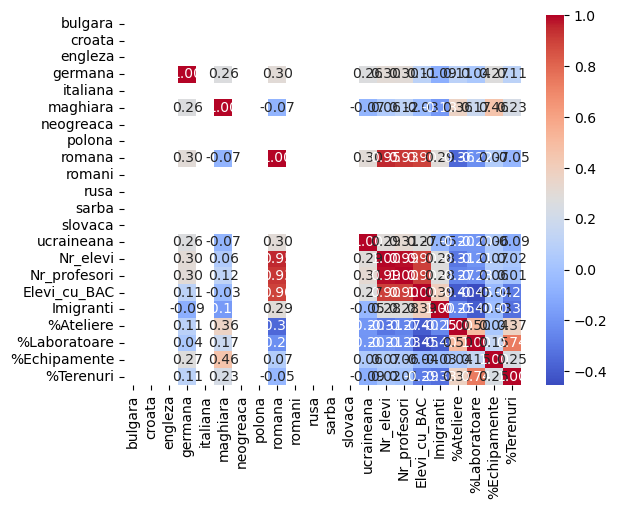

In [76]:
corelatii = data_clipped.corr()
sns.heatmap(corelatii, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [77]:
threshold = 0.7
coloane_eliminate = set()

for i in range(len(data_clipped.columns)):
    for j in range(i):
        if (data_clipped.iloc[i, j] >= threshold) and (data_clipped.columns[j] not in coloane_eliminate):
            coloane_eliminate.add(data_clipped.columns[i])

# Eliminare a coloanelor cu corelatii ridicate ce apar de mai multe ori
data_fara_corelatii_ridicate = data_clipped.drop(list(coloane_eliminate), axis=1)
print(data_fara_corelatii_ridicate)


    bulgara  croata  engleza  germana  neogreaca  polona  romani  rusa  \
0         0       0        0     1.00          0       0       0     0   
1         0       0        0     1.00          0       0       0     0   
2         0       0        0     0.00          0       0       0     0   
3         0       0        0     0.00          0       0       0     0   
4         0       0        0     1.00          0       0       0     0   
5         0       0        0     1.00          0       0       0     0   
6         0       0        0     0.00          0       0       0     0   
7         0       0        0     0.00          0       0       0     0   
8         0       0        0     2.95          0       0       0     0   
9         0       0        0     0.00          0       0       0     0   
10        0       0        0     0.00          0       0       0     0   
11        0       0        0     1.00          0       0       0     0   
12        0       0        0     1.00 

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

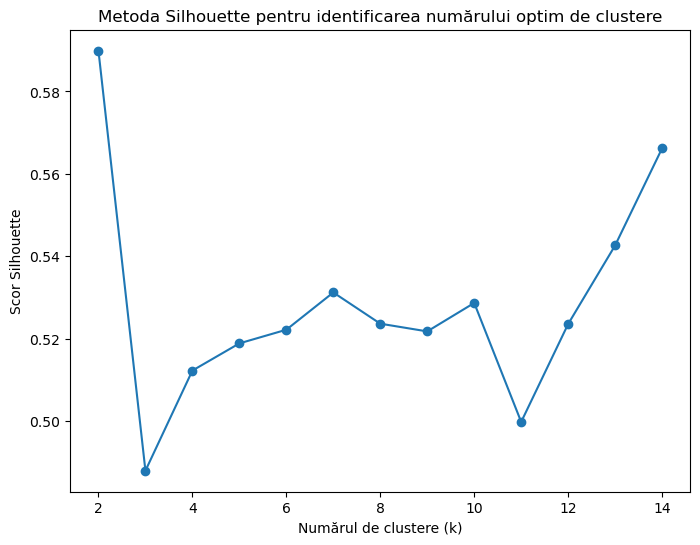

In [78]:
X = data_clipped

scoruri_silhouette = []
nr_clustere = range(2, 15)  

for k in nr_clustere:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scor_silhouette = silhouette_score(X, kmeans.labels_)
    scoruri_silhouette.append(scor_silhouette)

# Plotare grafic Silhouette
plt.figure(figsize=(8, 6))
plt.plot(nr_clustere, scoruri_silhouette, marker='o')
plt.xlabel('Numărul de clustere (k)')
plt.ylabel('Scor Silhouette')
plt.title('Metoda Silhouette pentru identificarea numărului optim de clustere')
plt.show()

In [83]:
y = data['Judet']

numar_clustere = 7
kmeans = KMeans(n_clusters=numar_clustere)
kmeans.fit(data_clipped)

etichete = kmeans.labels_
rezultate4 = pd.DataFrame({'Judet': y, 'Eticheta_Cluster': etichete})
print(rezultate2)

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Judet  Eticheta_Cluster
0              ALBA                 3
1              ARAD                 1
2             ARGES                 1
3             BACAU                 1
4             BIHOR                 4
5   BISTRITA-NASAUD                 3
6          BOTOSANI                 5
7            BRAILA                 0
8            BRASOV                 1
9             BUZAU                 3
10         CALARASI                 0
11    CARAS-SEVERIN                 3
12             CLUJ                 2
13        CONSTANTA                 2
14          COVASNA                 0
15        DAMBOVITA                 3
16             DOLJ                 4
17           GALATI                 5
18          GIURGIU                 0
19             GORJ                 3
20         HARGHITA                 3
21        HUNEDOARA                 1
22         IALOMITA                 0
23             IASI                 6
24            ILFOV                 3
25        MA

In [84]:
df = pd.DataFrame(rezultate4)

silhouette_avg = silhouette_score(data_clipped, df['Eticheta_Cluster'])
print(f"Scorul Silhouette este: {silhouette_avg}")

Scorul Silhouette este: 0.5621854075223044


In [85]:
y = data['Judet']
# V2
numar_clustere = 3
kmeans = KMeans(n_clusters=numar_clustere)
kmeans.fit(data_clipped)

etichete = kmeans.labels_
rezultate5 = pd.DataFrame({'Judet': y, 'Eticheta_Cluster': etichete})
print(rezultate5)

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Judet  Eticheta_Cluster
0              ALBA                 0
1              ARAD                 0
2             ARGES                 0
3             BACAU                 0
4             BIHOR                 1
5   BISTRITA-NASAUD                 2
6          BOTOSANI                 0
7            BRAILA                 2
8            BRASOV                 0
9             BUZAU                 0
10         CALARASI                 2
11    CARAS-SEVERIN                 2
12             CLUJ                 1
13        CONSTANTA                 1
14          COVASNA                 2
15        DAMBOVITA                 0
16             DOLJ                 1
17           GALATI                 0
18          GIURGIU                 2
19             GORJ                 0
20         HARGHITA                 2
21        HUNEDOARA                 0
22         IALOMITA                 2
23             IASI                 1
24            ILFOV                 2
25        MA

In [86]:
df = pd.DataFrame(rezultate5)

silhouette_avg = silhouette_score(data_clipped, df['Eticheta_Cluster'])
print(f"Scorul Silhouette este: {silhouette_avg}")

Scorul Silhouette este: 0.4880168216817032


### Clusterizare a tuturor datelor fara a tine cont de corelatii

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

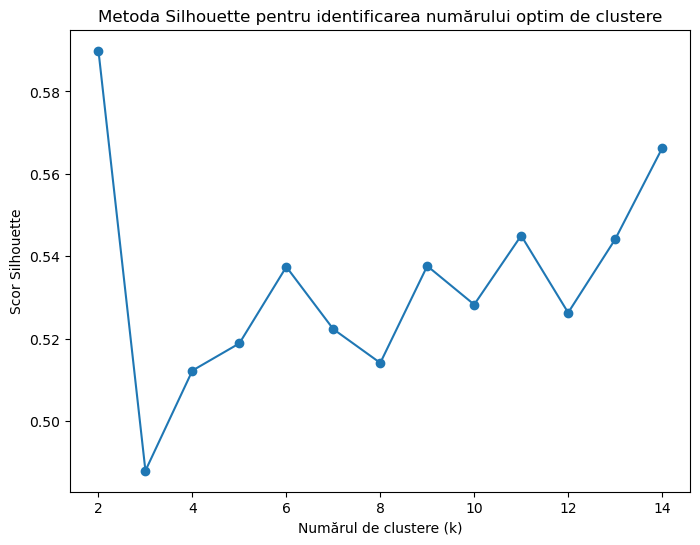

In [87]:
X = data_clipped

scoruri_silhouette = []
nr_clustere = range(2, 15)  

for k in nr_clustere:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scor_silhouette = silhouette_score(X, kmeans.labels_)
    scoruri_silhouette.append(scor_silhouette)

# Plotare grafic Silhouette
plt.figure(figsize=(8, 6))
plt.plot(nr_clustere, scoruri_silhouette, marker='o')
plt.xlabel('Numărul de clustere (k)')
plt.ylabel('Scor Silhouette')
plt.title('Metoda Silhouette pentru identificarea numărului optim de clustere')
plt.show()

In [89]:
y = data['Judet']

numar_clustere = 9
kmeans = KMeans(n_clusters=numar_clustere)
kmeans.fit(data_clipped)

etichete = kmeans.labels_
rezultate6 = pd.DataFrame({'Judet': y, 'Eticheta_Cluster': etichete})
print(rezultate6)

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Judet  Eticheta_Cluster
0              ALBA                 0
1              ARAD                 3
2             ARGES                 3
3             BACAU                 3
4             BIHOR                 4
5   BISTRITA-NASAUD                 7
6          BOTOSANI                 8
7            BRAILA                 7
8            BRASOV                 3
9             BUZAU                 0
10         CALARASI                 2
11    CARAS-SEVERIN                 7
12             CLUJ                 1
13        CONSTANTA                 1
14          COVASNA                 2
15        DAMBOVITA                 0
16             DOLJ                 4
17           GALATI                 8
18          GIURGIU                 2
19             GORJ                 0
20         HARGHITA                 0
21        HUNEDOARA                 3
22         IALOMITA                 2
23             IASI                 5
24            ILFOV                 7
25        MA

In [90]:
df = pd.DataFrame(rezultate6)

silhouette_avg = silhouette_score(data_clipped, df['Eticheta_Cluster'])
print(f"Scorul Silhouette este: {silhouette_avg}")

Scorul Silhouette este: 0.521806066160536


In [98]:
np.asarray(data_clipped)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.30000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.14190000e+04, 2.41600000e+03,
        1.81700000e+03, 2.15000000e+02, 4.51293341e+00, 8.91579527e+00,
        2.68684645e+02, 2.03632361e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.00000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.16430000e+04, 3.16600000e+03,
        2.04700000e+03, 3.15000000e+02, 4.20127015e+00, 1.02100635e+01,
        1.83634587e+02, 2.49145090e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.30000000e+01, 0.00000000e+00, 0.00000000e+00

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

caracteristici = data_clipped  # Separarea target-ului Judet
judet = data['Judet']

# train / test
X_train, X_test, y_train, y_test = train_test_split(caracteristici, judet, test_size=0.3, random_state=42)

# Antrenarea modelului de Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Realizarea predictii pe test
predictions = model.predict(X_test)

# Evaluare
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))

Accuracy: 0.0
              precision    recall  f1-score   support

       ARGES       0.00      0.00      0.00       0.0
       BACAU       0.00      0.00      0.00       0.0
       BIHOR       0.00      0.00      0.00       1.0
    BOTOSANI       0.00      0.00      0.00       1.0
      BRASOV       0.00      0.00      0.00       1.0
   BUCURESTI       0.00      0.00      0.00       1.0
       BUZAU       0.00      0.00      0.00       0.0
        CLUJ       0.00      0.00      0.00       1.0
   CONSTANTA       0.00      0.00      0.00       1.0
      GALATI       0.00      0.00      0.00       1.0
        GORJ       0.00      0.00      0.00       1.0
   HUNEDOARA       0.00      0.00      0.00       0.0
    IALOMITA       0.00      0.00      0.00       0.0
   MARAMURES       0.00      0.00      0.00       1.0
   MEHEDINTI       0.00      0.00      0.00       1.0
       MURES       0.00      0.00      0.00       0.0
       NEAMT       0.00      0.00      0.00       1.0
         OLT 

C:\Users\40751\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\40751\anaconda3\Lib\site-packages\sklearn\metrics\_cla